# RA2CE feature: Direct analysis

Three types of damage curves can be introduced to this analysis:
- Huizinga
- OSdaMage 
- User defined

# The Huizinga damage functions

This type of damage functions are initially developed for grid-based models, and generates damage per m2. For use in raster-based models, Huizinga (2007) developed a set of damage functions for diverse land use classes including transport infrastructure, initially for the European Union and later generalized worldwide (Huizinga et al., 2017). ‘Infrastructure’ is defined as physical damage to “roads and railroads as a result of contact with (fast flowing) water” (Huizinga et al., 2017, p.96). 

This type is adapted by Van Ginkel et al. (2021) for use object-based models such as RA2CE, which can be implemented easily across the globe. The grid-based Huizinga (2007, 2017) infrastructure damage function is expressed in euros damage per inundated area (€/m2). The maximum damage for road infrastructure is 25 €/m2. To apply this function in the object-based model, they are multiplied by typical road widths (m) to obtain damage functions per unit road length

It is good to mention that this method is known to (strongly) underestimate damage to high-end road infrastructure such as motorways with street lighting (Van Ginkel et al., 2021); (strongly) overestimate damage to cheap roads in the underlying road networks, such small residential roads, unpaved roads and tracks; underestimate damage to bridges (Jongman et al., 2012).


## An example for the Huizinga damage function

In this notebook, we provide an example for an event-based object-oriented Huizinga analysis.

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import rasterio

In [2]:
from ra2ce.ra2ce_handler import Ra2ceHandler #import the ra2cehandler to run ra2ce analyses

c:\repos\ra2ce\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
root_dir = Path(r'C:\repos\ra2ce\examples\data\direct_analysis')

#### Introducing a hazardous event

To use the flood map with RA2CE, we need to fill in the **[hazard]** section in the network.ini. 

Specify the flood map name in the **hazard_map** parameter in network.ini. RA2CE expects the flood map to be located in the *hazard* folder. The **aggregate_wl** parameter in analysis.ini can be set to either 'max', 'min' or 'mean' to take the maximum, minimum or mean water depth per road segment when the exposure of the roads to a certain hazard (map) is determined.<br>

Set the right CRS for the flood map in the **hazard_crs** parameter. This CRS can be different from the origins, destinations and road network. RA2CE will reproject the network to the CRS of the flood map and will reproject the road back to the original CRS when the CRS differs.

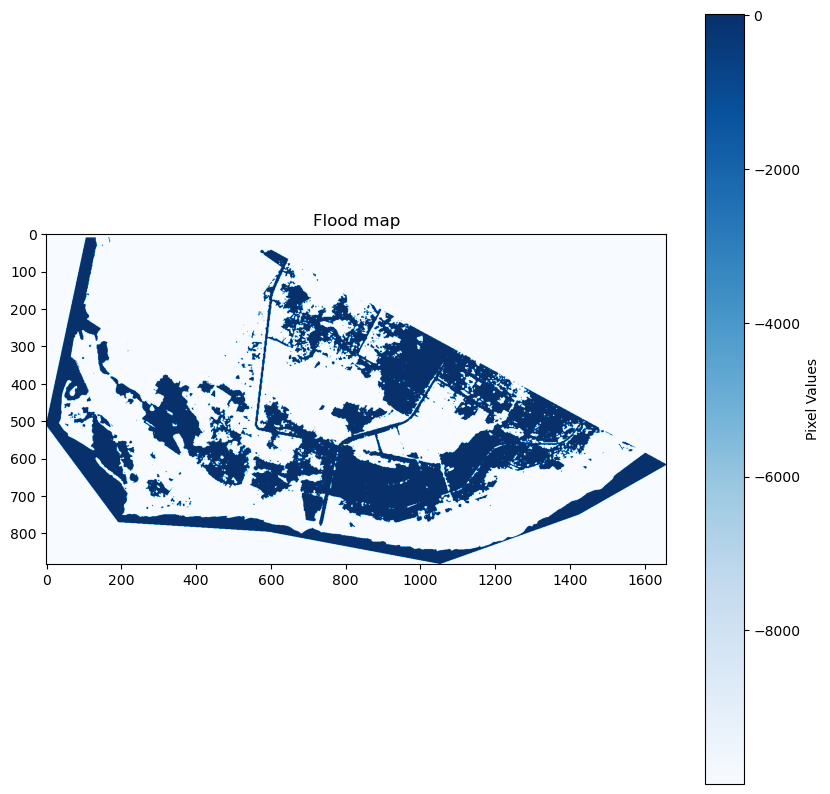

In [4]:
hazard_folder = root_dir / "static" / "hazard" # find the hazard folder where you locate your floo dmap
hazard_map = hazard_folder / "max_flood_depth.tif" # set the location of the hazard map

# Open the TIF file using rasterio
with rasterio.open(hazard_map) as src:
    # Read the TIF file as a numpy array
    tif_array = src.read(1)  # Change the band index (1) if necessary

plt.figure(figsize=(10, 10))
plt.imshow(tif_array, cmap='Blues')  # Change the colormap if desired
plt.colorbar(label='Pixel Values')
plt.title('Flood map')
plt.show()


#### Specifying the .ini files

**Network.ini content**
<br>
<br>
> [project]<br>
name = beira<br>
<br>
[network]<br>
**directed = False<br>
source = OSM download<br>
primary_file = None<br>
diversion_file = None<br>
file_id = rfid_c<br>
polygon = region_polygon.geojson<br>
network_type = drive<br>
road_types = motorway,motorway_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link,residential<br>
save_shp = True**<br>
<br>
[origins_destinations]<br>
**origins = None<br>
destinations = None<br>
origins_names = None<br>
destinations_names = None<br>
id_name_origin_destination = None<br>
origin_count = None<br>
origin_out_fraction = None<br>
category = categNoneory**<br>
<br>
[hazard]<br>
**hazard_map = max_flood_depth.tif<br>
hazard_id = None<br>
hazard_field_name = waterdepth<br>
aggregate_wl = max<br>
hazard_crs = EPSG:32736**<br>
<br>
*[cleanup]<br>
snapping_threshold = None<br>
segmentation_length = None<br>
merge_lines = True<br>
merge_on_id = False<br>
cut_at_intersections = False<br>*

We now need to update our analysis initialisation files using the preferred OD-analysis (there are multiple). We will consider the **direct** analysis. With the **aggregate_wl** parameter, the user can choose which type of aggregation of the water level on the road segment (max, mean, min) the analysis should consider. For the direct analysis, the **aggregate_wl=mean** makes sense. 

The **damage_curve** defines the damage curve type. ‘HZ’ to use the Huizinga damage function, ‘OSD’ to use the OSdaMage functions, and ‘MAN’ to use damage functions from manually inserted files. The **event_type** defines the type of the hazardous event, which is either 'event', or 'return_period'. The former is an one-time event, while the later will be applied for the events witha probability of occurance.

**[analysis1]**
<br>
<br>
name = Huizinga_direct_damage_event<br>
analysis = direct<br>
event_type = event<br>
damage_curve = HZ<br>
save_shp =True<br>
save_csv = True<br>
save_gpkg =True<br>

Set the paths to the initialization files and check if the files exist.

In [5]:
_network_ini_name = "network.ini" #set the name for the network.ini
_analysis_ini_name = "analysis.ini" #set the name for the analysis.ini

network_ini = root_dir / _network_ini_name
assert network_ini.is_file()

analysis_ini = root_dir / _analysis_ini_name
assert analysis_ini.is_file()

Run RA2CE.

In [6]:
handler = Ra2ceHandler(network=network_ini, analysis=analysis_ini)
handler.configure()
handler.run_analysis()

2023-11-17 04:13:49 PM - [ra2ce_logging.py:41] - root - INFO - RA2CE logger initialized.
2023-11-17 04:13:49 PM - [network_config_wrapper.py:106] - root - INFO - Existing graph/network found: C:\repos\ra2ce\examples\data\direct_analysis\static\output_graph\base_graph.p.
2023-11-17 04:13:49 PM - [network_config_wrapper.py:106] - root - INFO - Existing graph/network found: C:\repos\ra2ce\examples\data\direct_analysis\static\output_graph\base_network.feather.
2023-11-17 04:13:49 PM - [network_config_wrapper.py:106] - root - INFO - Existing graph/network found: C:\repos\ra2ce\examples\data\direct_analysis\static\output_graph\base_graph_hazard.p.
2023-11-17 04:13:49 PM - [networks.py:183] - root - INFO - Apparently, you already did create a network with ra2ce earlier. Ra2ce will use this: C:\repos\ra2ce\examples\data\direct_analysis\static\output_graph\base_graph.p
2023-11-17 04:13:49 PM - [hazard_overlay.py:101] - root - INFO - Initialized hazard object.
2023-11-17 04:13:49 PM - [hazard_ov

#### Visualising the results

In [11]:
analysis_output_path = root_dir / "output" / "direct"
damage_gdf = gpd.read_file(analysis_output_path / 'Huizinga_direct_damage_event.gpkg')
damage_gdf.head() #show the origins

,osmid,oneway,infra_type,reversed,length,rfid_c,rfid,name,maxspeed,lanes,...,junction,bridge,F_EV1_mi,F_EV1_ma,F_EV1_me,F_EV1_fr,road_type,lanes_copy,dam_EV1_HZ,geometry
0,44785078,True,tertiary,False,35.0,1,2,None,None,2.0,...,None,None,NaN,NaN,NaN,0.0,tertiary,2.0,NaN,"LINESTRING (34.87673 -19.85047, 34.87642 -19.8..."
1,820923407,False,tertiary,True,70.0,2,1,Ava Mártires da Revolução,60,2.0,...,None,None,NaN,NaN,NaN,0.0,tertiary,2.0,NaN,"LINESTRING (34.87673 -19.85047, 34.87737 -19.8..."
2,44794760,False,tertiary,False,12.0,3,3248,Rua Carlos Pereira,60,2.0,...,None,None,NaN,NaN,NaN,0.0,tertiary,2.0,NaN,"LINESTRING (34.89940 -19.84205, 34.89937 -19.8..."
3,44794760,False,tertiary,True,17.0,4,1090,Rua Carlos Pereira,60,2.0,...,None,None,NaN,NaN,NaN,0.0,tertiary,2.0,NaN,"LINESTRING (34.89940 -19.84205, 34.89943 -19.8..."
4,44794760,False,tertiary,False,14.0,5,1089,Rua Carlos Pereira,60,2.0,...,None,None,NaN,NaN,NaN,0.0,tertiary,2.0,NaN,"LINESTRING (34.89778 -19.84420, 34.89767 -19.8..."


In [57]:
null_mask = damage_gdf['dam_EV1_HZ'].isnull()
damage_gdf.loc[null_mask, 'dam_EV1_HZ'] = damage_gdf.loc[null_mask, 'dam_EV1_HZ'].replace({np.nan: 0})
# damage_gdf.explore(column='dam_EV1_HZ', tiles="CartoDB dark_matter")
import folium
from branca.colormap import LinearColormap

# Create a colormap
colormap = LinearColormap(['yellow', 'orange', 'red'], vmin=0, vmax=damage_gdf['dam_EV1_HZ'].max(), caption='dam_EV1_HZ')

# Create a Folium map centered around the mean of the geometry
center = [damage_gdf['geometry'].centroid.y.mean(), damage_gdf['geometry'].centroid.x.mean()]
m = folium.Map(location=center, zoom_start=12, control_scale=True, tiles="CartoDB dark_matter")

# Add edges to the map
for idx, row in damage_gdf.iterrows():
    color = 'darkgray' if row['dam_EV1_HZ'] == 0 else colormap(row['dam_EV1_HZ'])
    
    # Extracting coordinates from LineString
    coordinates = [(coord[1], coord[0]) for coord in row['geometry'].coords]

    # Create a popup with data
    popup_content = f"<strong>dam_EV1_HZ:</strong> {row['dam_EV1_HZ']}"
    popup = folium.Popup(popup_content, max_width=300)
    
    folium.PolyLine(
        locations=coordinates,
        color=color,
        weight=2,
        opacity=1,
        popup=popup
    ).add_to(m)

# Add colormap to the map
colormap.add_to(m)

# Display the map
m

TypeError: 'list' object is not callable